### Avarage landmark movement pain dataset comapared between different classes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
COLAB_ROOT = "/content/drive/MyDrive/PainRecognitionProject/"
DATA_DIR = os.path.join(
    COLAB_ROOT,
    "data/BioVid_HeatPain_processed_478_xyz_frontalized/"
)
METADATA_PATH = os.path.join(DATA_DIR, "train_processed_metadata.csv")


In [4]:
MAX_SAMPLES_PER_CLASS = 1
MAX_FRAMES = 46
CENTER_POINT_INDEX = 2

PAIN_MAP = {
    0: "HP0: Brak bólu",
    1: "HP1: Ból słaby",
    2: "HP2: Ból średni",
    3: "HP3: Ból silny",
    4: "HP4: Ból maksymalny",
}

In [5]:
def compute_central_distance(sequence_np, center_idx=CENTER_POINT_INDEX):
    """
    sequence_np: (T, 1434) = 478 punktów * (X,Y,Z)
    Zwraca: (T,) – średni dystans L2 punktów od nosa w każdej klatce
    """
    T, F = sequence_np.shape
    NUM_COORDS = 3
    N_POINTS = F // NUM_COORDS

    center_idx_xyz = [
        center_idx * 3,
        center_idx * 3 + 1,
        center_idx * 3 + 2
    ]
    center_coords = sequence_np[:, center_idx_xyz]

    points = sequence_np.reshape(T, N_POINTS, NUM_COORDS)

    center_repeated = center_coords[:, None, :]
    center_repeated = np.repeat(center_repeated, N_POINTS, axis=1)

    distances = np.linalg.norm(points - center_repeated, axis=2)

    mean_distance = distances.mean(axis=1)
    return mean_distance[:MAX_FRAMES]

#### Avarage landmarks movement for 5 classes for patient 071309_w_21

In [6]:
TARGET_LABELS = [0, 1, 2, 3, 4]
SELECTED_FILES_BY_LABEL = {
    0: "train/071309_w_21-BL1-081.npy",
    1: "train/071309_w_21-PA1-001.npy",
    2: "train/071309_w_21-PA2-004.npy",
    3: "train/071309_w_21-PA3-006.npy",
    4: "train/071309_w_21-PA4-002.npy",
}

In [7]:
df = pd.read_csv(METADATA_PATH)
data_by_label = {}

df_selected = pd.DataFrame()
for label, filename in SELECTED_FILES_BY_LABEL.items():
    row = df[(df["label"] == label) & (df["npy_path"].str.contains(filename, regex=False))]

    if row.empty:
        print(f"KRYTYCZNY BŁĄD: Nie znaleziono pliku '{filename}' o etykiecie {label} w metadanych!")
        continue

    df_selected = pd.concat([df_selected, row.iloc[[0]]], ignore_index=True)


for _, row in df_selected.iterrows():
    label = row['label']
    filename = os.path.basename(row["npy_path"])
    npy_path = os.path.join(DATA_DIR, "train", filename)

    if not os.path.exists(npy_path):
        print(f"Brak pliku: {npy_path}")
        continue

    seq = np.load(npy_path).astype(np.float32)

    data_by_label[label] = [seq]
    print(f"✔ {PAIN_MAP[label]} → Załadowano sekwencję: {filename}")


✔ HP0: Brak bólu → Załadowano sekwencję: 071309_w_21-BL1-081.npy
✔ HP1: Ból słaby → Załadowano sekwencję: 071309_w_21-PA1-001.npy
✔ HP2: Ból średni → Załadowano sekwencję: 071309_w_21-PA2-004.npy
✔ HP3: Ból silny → Załadowano sekwencję: 071309_w_21-PA3-006.npy
✔ HP4: Ból maksymalny → Załadowano sekwencję: 071309_w_21-PA4-002.npy


In [8]:
curves = []
min_len = MAX_FRAMES

for label, sequences in data_by_label.items():
    if not sequences:
        continue

    curve = compute_central_distance(sequences[0])
    curves.append((label, curve))
    min_len = min(min_len, len(curve))

if min_len == 0:
    raise RuntimeError("Brak poprawnych danych do analizy")

mean_distances = {
    label: curve[:min_len]
    for label, curve in curves
}

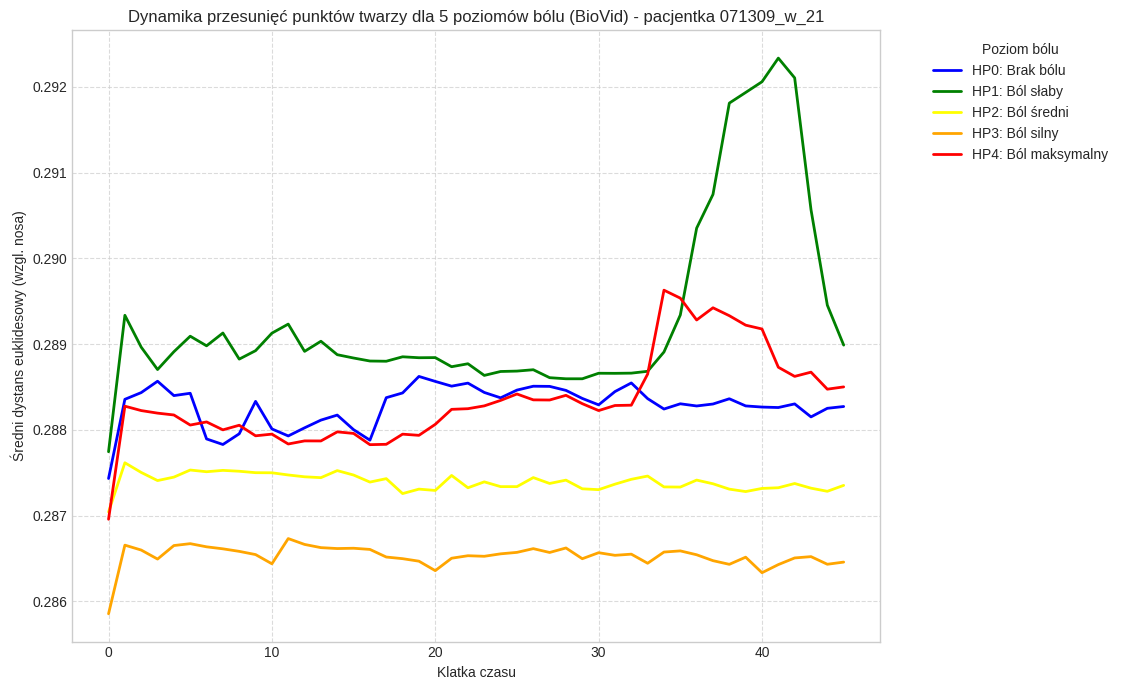

In [9]:
plt.figure(figsize=(12, 7))
plt.style.use("seaborn-v0_8-whitegrid")

plot_styles = {
    0: ("blue", "-"),
    1: ("green", "-"),
    2: ("yellow", "-"),
    3: ("orange", "-"),
    4: ("red", "-"),
}

for label, curve in mean_distances.items():
    color, linestyle = plot_styles[label]
    plt.plot(
        curve,
        label=PAIN_MAP[label],
        color=color,
        linestyle=linestyle,
        linewidth=2
    )

plt.xlabel(f"Klatka czasu")
plt.ylabel("Średni dystans euklidesowy (wzgl. nosa)")
plt.title("Dynamika przesunięć punktów twarzy dla 5 poziomów bólu (BioVid) - pacjentka 071309_w_21")
plt.legend(title="Poziom bólu", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


#### Avarage landmarks movement for 2 classes for patient 071309_w_21

In [10]:
TARGET_LABELS = [0, 4]
PAIN_MAP = {
    0: "HP0: Brak bólu",
    1: "HP1: Ból słaby",
    2: "HP2: Ból średni",
    3: "HP3: Ból silny",
    4: "HP4: Ból maksymalny",
}

SELECTED_FILES_BY_LABEL = {
    0: "train/071309_w_21-BL1-081.npy",
    4: "train/071309_w_21-PA4-002.npy",
}

In [11]:
df = pd.read_csv(METADATA_PATH)
data_by_label = {}

df_selected = pd.DataFrame()
for label, filename in SELECTED_FILES_BY_LABEL.items():
    row = df[(df["label"] == label) & (df["npy_path"].str.contains(filename, regex=False))]

    if row.empty:
        print(f"KRYTYCZNY BŁĄD: Nie znaleziono pliku '{filename}' o etykiecie {label} w metadanych!")
        continue

    df_selected = pd.concat([df_selected, row.iloc[[0]]], ignore_index=True)


for _, row in df_selected.iterrows():
    label = row['label']
    filename = os.path.basename(row["npy_path"])
    npy_path = os.path.join(DATA_DIR, "train", filename)

    if not os.path.exists(npy_path):
        print(f"Brak pliku: {npy_path}")
        continue

    seq = np.load(npy_path).astype(np.float32)

    data_by_label[label] = [seq]
    print(f"✔ {PAIN_MAP[label]} → Załadowano sekwencję: {filename}")


✔ HP0: Brak bólu → Załadowano sekwencję: 071309_w_21-BL1-081.npy
✔ HP4: Ból maksymalny → Załadowano sekwencję: 071309_w_21-PA4-002.npy


In [12]:
curves = []
min_len = MAX_FRAMES

for label, sequences in data_by_label.items():
    if not sequences:
        continue

    curve = compute_central_distance(sequences[0])
    curves.append((label, curve))
    min_len = min(min_len, len(curve))

if min_len == 0:
    raise RuntimeError("Brak poprawnych danych do analizy")

mean_distances = {
    label: curve[:min_len]
    for label, curve in curves
}

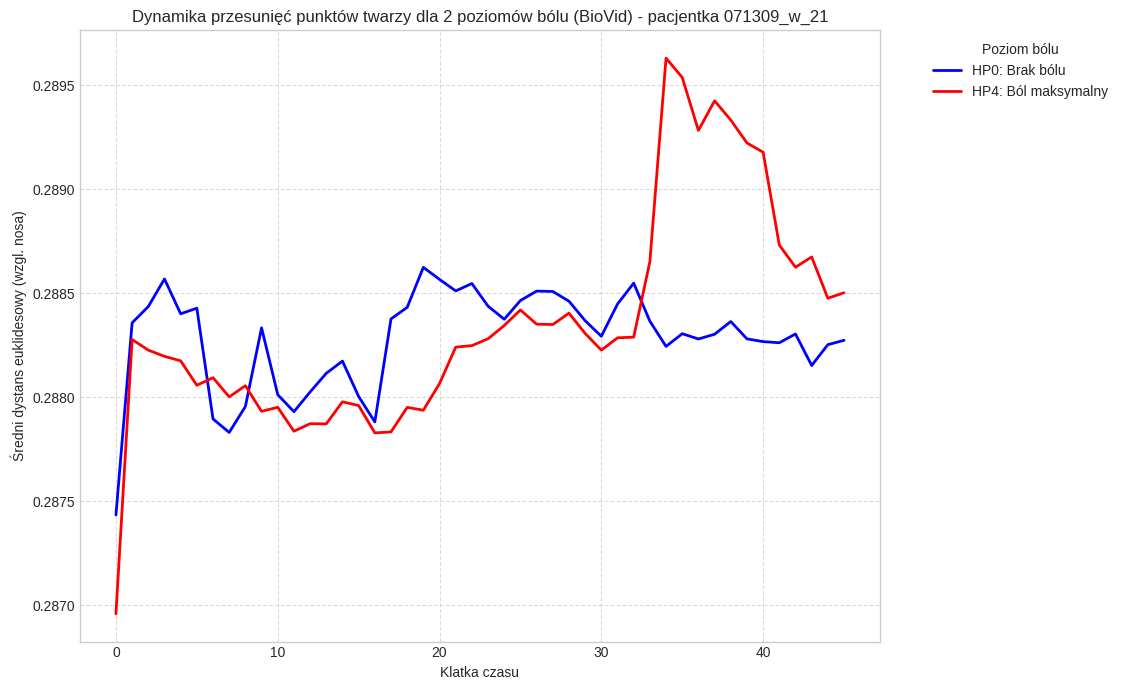

In [13]:
plt.figure(figsize=(12, 7))
plt.style.use("seaborn-v0_8-whitegrid")

plot_styles = {
    0: ("blue", "-"),
    1: ("green", "-"),
    2: ("yellow", "-"),
    3: ("orange", "-"),
    4: ("red", "-"),
}

for label, curve in mean_distances.items():
    color, linestyle = plot_styles[label]
    plt.plot(
        curve,
        label=PAIN_MAP[label],
        color=color,
        linestyle=linestyle,
        linewidth=2
    )

plt.xlabel(f"Klatka czasu")
plt.ylabel("Średni dystans euklidesowy (wzgl. nosa)")
plt.title("Dynamika przesunięć punktów twarzy dla 2 poziomów bólu (BioVid) - pacjentka 071309_w_21")
plt.legend(title="Poziom bólu", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


#### Avarage landmarks movement for 5 classes for patient 100909_w_65

In [14]:
TARGET_LABELS = [0, 1, 2, 3, 4]
PAIN_MAP = {
    0: "HP0: Brak bólu",
    1: "HP1: Ból słaby",
    2: "HP2: Ból średni",
    3: "HP3: Ból silny",
    4: "HP4: Ból maksymalny",
}

SELECTED_FILES_BY_LABEL = {
    0: "train/100909_w_65-BL1-081.npy",
    1: "train/100909_w_65-PA1-003.npy",
    2: "train/100909_w_65-PA2-007.npy",
    3: "train/100909_w_65-PA3-062.npy",
    4: "train/100909_w_65-PA4-056.npy",
}

In [15]:
df = pd.read_csv(METADATA_PATH)
data_by_label = {}

df_selected = pd.DataFrame()
for label, filename in SELECTED_FILES_BY_LABEL.items():
    row = df[(df["label"] == label) & (df["npy_path"].str.contains(filename, regex=False))]

    if row.empty:
        print(f"KRYTYCZNY BŁĄD: Nie znaleziono pliku '{filename}' o etykiecie {label} w metadanych!")
        continue

    df_selected = pd.concat([df_selected, row.iloc[[0]]], ignore_index=True)


for _, row in df_selected.iterrows():
    label = row['label']
    filename = os.path.basename(row["npy_path"])
    npy_path = os.path.join(DATA_DIR, "train", filename)

    if not os.path.exists(npy_path):
        print(f"Brak pliku: {npy_path}")
        continue

    seq = np.load(npy_path).astype(np.float32)

    data_by_label[label] = [seq]
    print(f"✔ {PAIN_MAP[label]} → Załadowano sekwencję: {filename}")


✔ HP0: Brak bólu → Załadowano sekwencję: 100909_w_65-BL1-081.npy
✔ HP1: Ból słaby → Załadowano sekwencję: 100909_w_65-PA1-003.npy
✔ HP2: Ból średni → Załadowano sekwencję: 100909_w_65-PA2-007.npy
✔ HP3: Ból silny → Załadowano sekwencję: 100909_w_65-PA3-062.npy
✔ HP4: Ból maksymalny → Załadowano sekwencję: 100909_w_65-PA4-056.npy


In [16]:
curves = []
min_len = MAX_FRAMES

for label, sequences in data_by_label.items():
    if not sequences:
        continue

    curve = compute_central_distance(sequences[0])
    curves.append((label, curve))
    min_len = min(min_len, len(curve))

if min_len == 0:
    raise RuntimeError("Brak poprawnych danych do analizy")

mean_distances = {
    label: curve[:min_len]
    for label, curve in curves
}

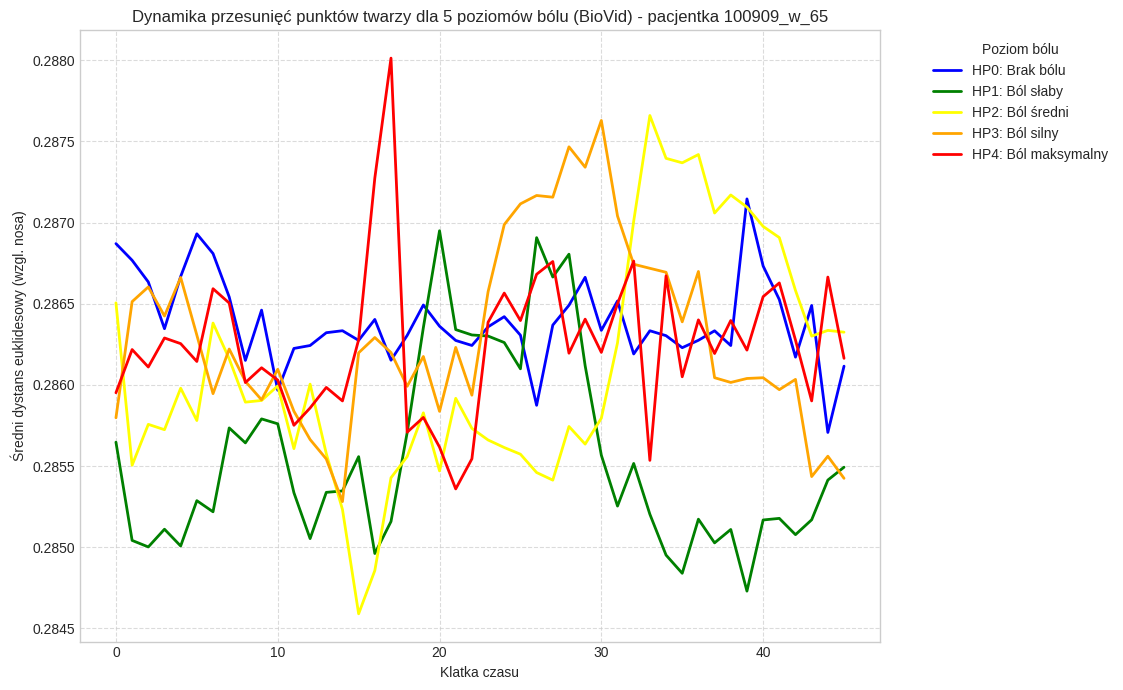

In [17]:
plt.figure(figsize=(12, 7))
plt.style.use("seaborn-v0_8-whitegrid")

plot_styles = {
    0: ("blue", "-"),
    1: ("green", "-"),
    2: ("yellow", "-"),
    3: ("orange", "-"),
    4: ("red", "-"),
}

for label, curve in mean_distances.items():
    color, linestyle = plot_styles[label]
    plt.plot(
        curve,
        label=PAIN_MAP[label],
        color=color,
        linestyle=linestyle,
        linewidth=2
    )

plt.xlabel(f"Klatka czasu")
plt.ylabel("Średni dystans euklidesowy (wzgl. nosa)")
plt.title("Dynamika przesunięć punktów twarzy dla 5 poziomów bólu (BioVid) - pacjentka 100909_w_65")
plt.legend(title="Poziom bólu", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()


#### Avarage landmarks movement for 2 classes for patient 100909_w_65

In [18]:
TARGET_LABELS = [0, 4]
PAIN_MAP = {
    0: "HP0: Brak bólu",
    1: "HP1: Ból słaby",
    2: "HP2: Ból średni",
    3: "HP3: Ból silny",
    4: "HP4: Ból maksymalny",
}

SELECTED_FILES_BY_LABEL = {
    0: "train/100909_w_65-BL1-081.npy",
    4: "train/100909_w_65-PA4-056.npy",
}

In [19]:
df = pd.read_csv(METADATA_PATH)
data_by_label = {}

df_selected = pd.DataFrame()
for label, filename in SELECTED_FILES_BY_LABEL.items():
    row = df[(df["label"] == label) & (df["npy_path"].str.contains(filename, regex=False))]

    if row.empty:
        print(f"KRYTYCZNY BŁĄD: Nie znaleziono pliku '{filename}' o etykiecie {label} w metadanych!")
        continue

    df_selected = pd.concat([df_selected, row.iloc[[0]]], ignore_index=True)


for _, row in df_selected.iterrows():
    label = row['label']
    filename = os.path.basename(row["npy_path"])
    npy_path = os.path.join(DATA_DIR, "train", filename)

    if not os.path.exists(npy_path):
        print(f"Brak pliku: {npy_path}")
        continue

    seq = np.load(npy_path).astype(np.float32)

    data_by_label[label] = [seq]
    print(f"✔ {PAIN_MAP[label]} → Załadowano sekwencję: {filename}")


✔ HP0: Brak bólu → Załadowano sekwencję: 100909_w_65-BL1-081.npy
✔ HP4: Ból maksymalny → Załadowano sekwencję: 100909_w_65-PA4-056.npy


In [20]:
curves = []
min_len = MAX_FRAMES

for label, sequences in data_by_label.items():
    if not sequences:
        continue

    curve = compute_central_distance(sequences[0])
    curves.append((label, curve))
    min_len = min(min_len, len(curve))

if min_len == 0:
    raise RuntimeError("Brak poprawnych danych do analizy")

mean_distances = {
    label: curve[:min_len]
    for label, curve in curves
}



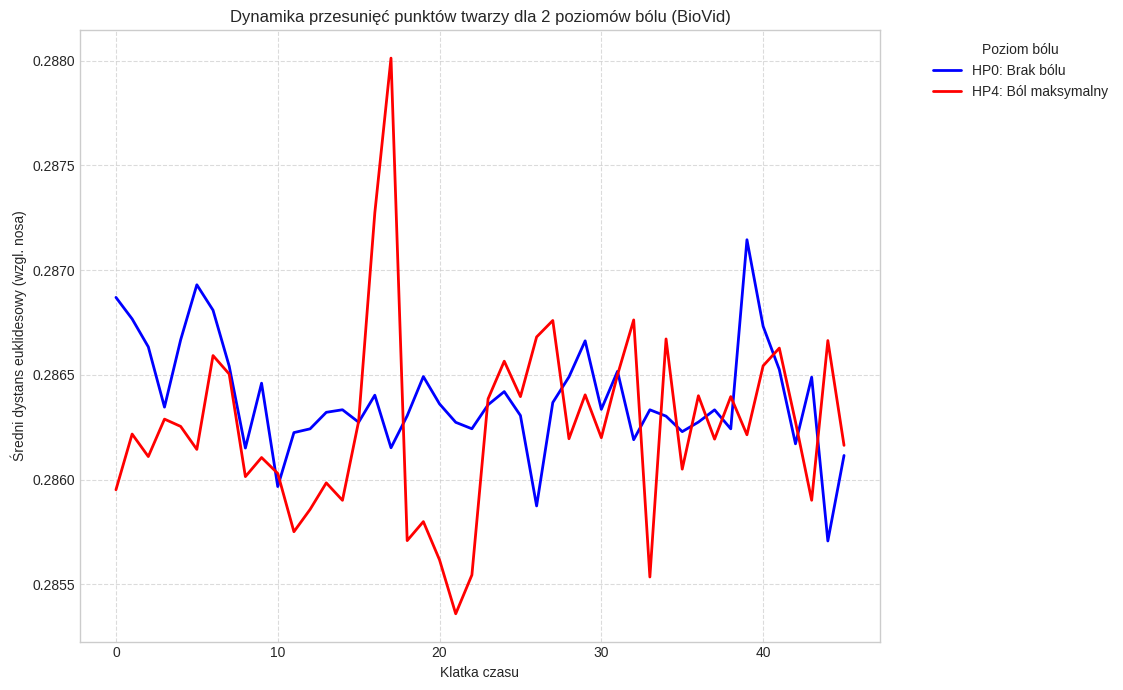

In [21]:
plt.figure(figsize=(12, 7))
plt.style.use("seaborn-v0_8-whitegrid")

plot_styles = {
    0: ("blue", "-"),
    1: ("green", "-"),
    2: ("yellow", "-"),
    3: ("orange", "-"),
    4: ("red", "-"),
}

for label, curve in mean_distances.items():
    color, linestyle = plot_styles[label]
    plt.plot(
        curve,
        label=PAIN_MAP[label],
        color=color,
        linestyle=linestyle,
        linewidth=2
    )

plt.xlabel(f"Klatka czasu")
plt.ylabel("Średni dystans euklidesowy (wzgl. nosa)")
plt.title("Dynamika przesunięć punktów twarzy dla 2 poziomów bólu (BioVid)")
plt.legend(title="Poziom bólu", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()
